<h1 align="center"> Lending Club Loan Analysis </h1> <br>

## Part 0: Data Cleaning<br><br>
Clean the data

## Part 1: Data Exploration and Evaluation<br><br>
Lending Club's new issuance has ramped exponentially over the past few years.  
The average interest rate is 13.3%, and historically 13% of their loans default in some manner.  However, both the interest rate, and historical default rate, vary considerably grade.
For our future analysis on 36 month loans, we must limit our loans to loans issued Dec. 2012 and earlier, as the last data we have is Jan 2016, and the return statistics when looking excluding un-finished paid loans is considerably different.

## Part 2: Business Analysis<br><br>
Including all historical complete loans, the average 36 month loan in this dataset yields 3.38%*.

However, this is misleading. This is excluding the majority of loans that are in progress from 2013-2016, but including defaults, chargeoffs, and prepayments.  

Specifically looking at completed 36 month loans for which this sampling issue isn't a problem, lending club loans have yielded a dollar weighted 7.347%*.

When we bucket by grade, and year, the highest rate of return is 2012 Grade Gs, yielding 18.88%*.

*Several assumptions go into this, detailed below.

## Part 3: Modeling<br><br>

A very simple heuristic is able to beat the benchmark - match the index for loan subgrade distribution, but select the highest interest rates for said subgrade.

I.E. Given the Choice between a B2 loan with an interest rate of 7.5% and 8%, pick the B2 loan with 8%.

With additional complexity, we can identify loans with higher expected returns, and in aggregate considerably boost the returns of the portfolio.
With our model, and some portfolio optimization, we can boost the sh

## Part 0: Data Cleaning<br><br>

In [88]:
from plotnine import *
from plotnine.data import *

from mizani.breaks import date_breaks
from mizani.formatters import date_format


In [90]:
# Import our libraries we are going to use for our data analysis.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Plotly visualizations
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# plotly.tools.set_credentials_file(username='AlexanderBach', api_key='o4fx6i1MtEIJQxfWYvU1')


% matplotlib inline

dfloan = pd.read_csv('../input/loan.csv', low_memory=False)

# Copy of the dataframe
original_df = dfloan.copy()
dfloan = original_df
dfloan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
dfloan['issue_date']= pd.to_datetime(dfloan['issue_d'])
dfloan['credit_pull_date']= pd.to_datetime(dfloan['last_credit_pull_d'])
dfloan['earliest_credit']= pd.to_datetime(dfloan['earliest_cr_line'])
dfloan['last_pymnt_date']= pd.to_datetime(dfloan['last_pymnt_d'])



In [5]:
monthseq = pd.DataFrame({'date':pd.date_range(start='2005-01-01', end='2018-01-01', freq='MS')})
monthseq['index'] = np.arange(1,monthseq['date'].count()+1)
monthseq.head()

,date,index
0,2005-01-01,1
1,2005-02-01,2
2,2005-03-01,3
3,2005-04-01,4
4,2005-05-01,5


In [6]:
dfloan = dfloan.merge(monthseq.rename(columns={'index': 'issue_date_index',
                                               'date': 'issue_date'}),left_on='issue_date', right_on='issue_date', how='inner')
dfloan = dfloan.merge(monthseq.rename(columns={'index': 'last_payment_date_index',
                                               'date': 'last_pymnt_date'}),left_on='last_pymnt_date', right_on='last_pymnt_date', how='inner')
dfloan['months_apart'] = dfloan.last_payment_date_index - dfloan.issue_date_index
dfloan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,inq_fi,total_cu_tl,inq_last_12m,issue_date,credit_pull_date,earliest_credit,last_pymnt_date,issue_date_index,last_payment_date_index,months_apart
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,2011-12-01,2016-01-01,1985-01-01,2015-01-01,84,121,37
1,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,2011-12-01,2015-01-01,1996-02-01,2015-01-01,84,121,37
2,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,2011-12-01,2015-09-01,2004-11-01,2015-01-01,84,121,37
3,1072053,1288686,3000.0,3000.0,3000.0,36 months,18.64,109.43,E,E1,...,NaN,NaN,NaN,2011-12-01,2014-12-01,2007-01-01,2015-01-01,84,121,37
4,1069866,1304956,3000.0,3000.0,3000.0,36 months,9.91,96.68,B,B1,...,NaN,NaN,NaN,2011-12-01,2016-01-01,2003-07-01,2015-01-01,84,121,37


## Part 1: Data Exploration and Evaluation<br><br>

Lending Club's new issuance has ramped exponentially over the past few years.

*Data Overview*
* We have 887k loans in our dataset.
* Of these,  have 199k are complete.
* Of these, 74.8k were issued before 2013.

*Investment Criteria at a Glance*
* On 36 Month Loans, the average interest rate is 12.7%
* On 36 Month Loans completed loans, the rate of some form of default from loans issued from 2007-2012 is 12.9%

For our future analysis on 36 month loans, we must limit our loans to loans issued Dec. 2012 and earlier, as the last data we have is Jan 2016, and the return statistics when looking excluding un-finished paid loans is considerably different.


In [103]:
###Remove the loans where "fully paid" but total received principal meaningfully less than loan
dfloan = dfloan.query('(loan_status == "Fully Paid" & total_rec_prncp<funded_amnt-10)==False')
dfloan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
#Number of Loans
dfloan.shape[0]

886834

In [9]:
####Subset to useful columns######
##Assumption: collection recovery fee is a cost associated with recovery, not attirubtable to investor, correct?
dfloanUseful = dfloan[['id','issue_date','loan_amnt','funded_amnt','funded_amnt_inv',
                        'int_rate','grade','sub_grade',
                            'loan_status','recoveries','collection_recovery_fee',
                        'total_rec_int',
                            'total_rec_late_fee',
                            'total_rec_prncp',
                            'last_pymnt_date',
                            'last_pymnt_amnt',
                            'term',
                            'months_apart']]
dfloanUseful = dfloanUseful.rename(columns={'months_apart': 'loan_duration'})



In [92]:
###What is the total loan issuance by month?
x= dfloanUseful.query('loan_status == "Fully Paid"')[['loan_amnt','last_pymnt_date']].groupby('last_pymnt_date').agg([np.sum]).reset_index()
df = dfloanUseful[['loan_status','issue_date','loan_amnt']].groupby(['loan_status','issue_date']).sum().reset_index()

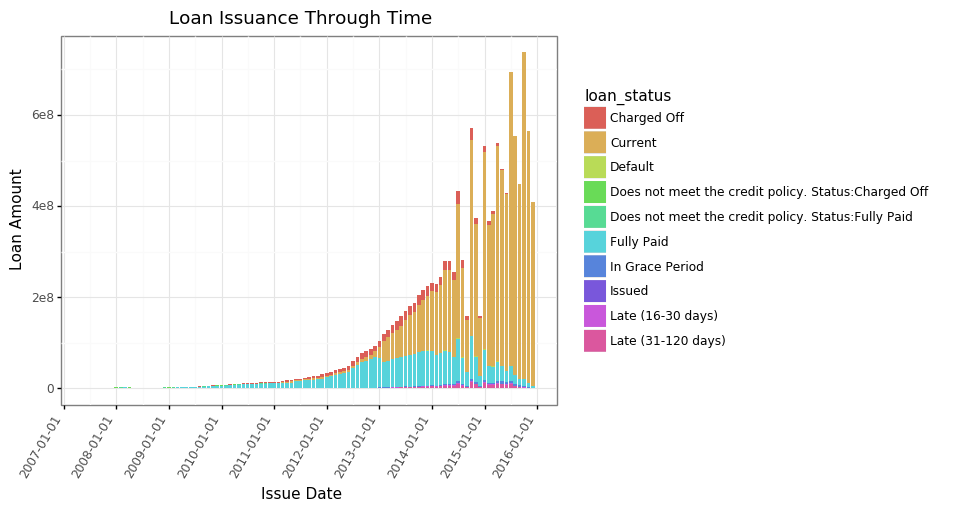

<ggplot: (-9223363292986855038)>

In [101]:
x = ggplot(df, aes(x='issue_date', y='loan_amnt', fill='loan_status')) + geom_bar(stat='identity')+  theme_bw() + ylab("Loan Amount") + xlab("Issue Date")+ scale_x_datetime(breaks=date_breaks('1 years'))+theme(axis_text_x=element_text(rotation=60, hjust=1))+ggtitle("Loan Issuance Through Time")
x

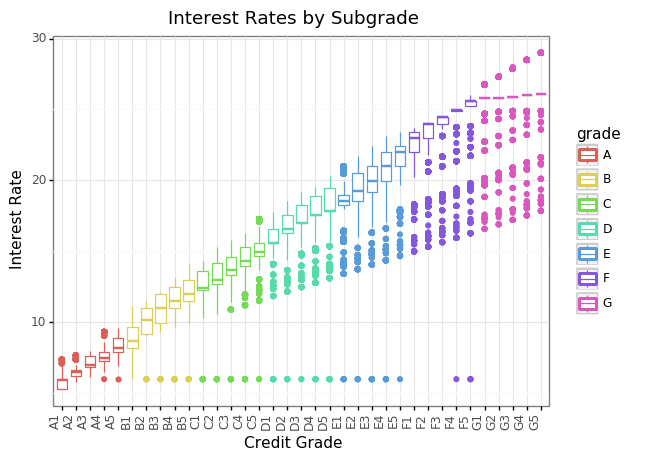

<ggplot: (-9223363292986865187)>

In [102]:
####How do credit grades effect the interest rate on a loan?
####Interest rates vary from ~5% to 28%.  Grade "As" tend to have rates between 6-9%, Bs between 9-13%, Cs between 13-16%,Ds between 16-19%, and Es, Fs, Gs all lower
x = ggplot(dfloanUseful, aes(x='sub_grade', y='int_rate', color='grade')) + geom_boxplot() +  theme_bw() + ylab("Interest Rate") + xlab("Credit Grade")+ theme(axis_text_x=element_text(rotation=90, hjust=1))+ggtitle("Interest Rates by Subgrade")
x

In [129]:
###Identify which loans are complete, and bad.
dfloanUseful['term2'] = dfloanUseful.term.str.strip()
dfloanUseful36 = dfloanUseful.query('term2 == "36 months"')
complete_loans = ['Charged Off','Default','Fully Paid',
                   'Does not meet the credit policy. Status:Fully Paid',
                   'Does not meet the credit policy. Status:Charged Off']

bad_loans = ['Charged Off','Default',
                   'Does not meet the credit policy. Status:Charged Off']

good_loans = ['Fully Paid','Does not meet the credit policy. Status:Fully Paid']

dfloanUseful36['loan_status'] = dfloanUseful36.loan_status.str.strip()
dfloanUseful36 = dfloanUseful36[dfloanUseful36.loan_status.isin(complete_loans)]
dfloanUseful36.head()

,id,issue_date,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,grade,sub_grade,loan_status,recoveries,collection_recovery_fee,total_rec_int,total_rec_late_fee,total_rec_prncp,last_pymnt_date,last_pymnt_amnt,term,loan_duration,term2
0,1077501,2011-12-01,5000.0,5000.0,4975.0,10.65,B,B2,Fully Paid,0.0,0.0,861.07,0.00,5000.0,2015-01-01,171.62,36 months,37,36 months
1,1076863,2011-12-01,10000.0,10000.0,10000.0,13.49,C,C1,Fully Paid,0.0,0.0,2209.33,16.97,10000.0,2015-01-01,357.48,36 months,37,36 months
2,1075269,2011-12-01,5000.0,5000.0,5000.0,7.90,A,A4,Fully Paid,0.0,0.0,631.38,0.00,5000.0,2015-01-01,161.03,36 months,37,36 months
3,1072053,2011-12-01,3000.0,3000.0,3000.0,18.64,E,E1,Fully Paid,0.0,0.0,938.14,0.00,3000.0,2015-01-01,111.34,36 months,37,36 months
4,1069866,2011-12-01,3000.0,3000.0,3000.0,9.91,B,B1,Fully Paid,0.0,0.0,478.98,0.00,3000.0,2015-01-01,102.43,36 months,37,36 months


In [127]:
###Number of complete, 36 month loans
print("36 month loans:")
print(dfloanUseful36.shape[0])


###Number of complete, 36 month loans issued before 2013
print("36 month loans issued before 2013:")
print(dfloanUseful36.query("issue_date<'2013-01-01'").shape[0])

36 month loans:
199009
36 month loans issued before 2013:
74758


In [128]:
###Average Interest Rate on 36 month loans
print("Interest Rate:")
print(np.round(dfloanUseful36.int_rate.mean(),1))

###Average Default Rate
loan2012 = dfloanUseful36.query("issue_date<'2013-01-01'")
print("Default:")
print(np.round(loan2012[loan2012.loan_status.isin(bad_loans)].shape[0]/loan2012.shape[0]*100,1))



Interest Rate:
12.7
Default:
12.9


## Part 2: Business Analysis<br><br>
Including all historical complete loans, the average 36 month loan in this dataset yields 3.38%*.

However, this is misleading. This is excluding the majority of loans that are in progress from 2013-2016, but including defaults, chargeoffs, and prepayments.  

Specifically looking at completed 36 month loans for which this sampling issue isn't a problem, **lending club loans have yielded a dollar weighted 7.32%*.**

When we bucket by grade, and year, **the highest rate of return is 2012 Grade Gs, yielding 18.88%*.**

*Several assumptions go into this, detailed below.


In [143]:
###This cell block does some data cleaing: standardizing repayment by month, and calculating an imprecise but roughly correct individual irr
dfLoanGroupUnderlying = dfloanUseful36
##For each month from the start to the end, figure out what the portfolio rate of return for all the laons was 

months = pd.date_range(start='2007-06-01', end='2016-01-01', freq='MS')

##Total Repayments is Total Received Interest, Late Fees, Principal, and Recoveries, Less Collection Recovery Fee
dfLoanGroupUnderlying['total_repayment'] = dfLoanGroupUnderlying.total_rec_int + dfLoanGroupUnderlying.total_rec_late_fee+dfLoanGroupUnderlying.total_rec_prncp+dfLoanGroupUnderlying.recoveries-dfLoanGroupUnderlying.collection_recovery_fee
####Assume loans are always paid linearly down, except for the final payment


dfLoanGroupUnderlying = dfLoanGroupUnderlying.query("loan_duration >0")  ###Loans that are repaid in the same month are excluded from the analysis


dfLoanGroupUnderlying['repayment_by_month']=(dfLoanGroupUnderlying.total_repayment-dfLoanGroupUnderlying.last_pymnt_amnt)/(dfLoanGroupUnderlying.loan_duration-1)
dfLoanGroupUnderlying['total_repayment'] = dfLoanGroupUnderlying.total_rec_int + dfLoanGroupUnderlying.total_rec_late_fee+dfLoanGroupUnderlying.total_rec_prncp+dfLoanGroupUnderlying.recoveries-dfLoanGroupUnderlying.collection_recovery_fee
dfLoanGroupUnderlying.head()
dfLoanGroupUnderlying.repayment_by_month.head()
dfLoanGroupUnderlying.loc[dfLoanGroupUnderlying.repayment_by_month<0,'repayment_by_month']=0
dfLoanGroupUnderlying.loc[dfLoanGroupUnderlying.loan_duration<=1,'repayment_by_month']=0
dfLoanGroupUnderlying.loc[dfLoanGroupUnderlying.loan_duration<=1,'last_pymnt_amnt']=dfLoanGroupUnderlying.query("loan_duration<=1").total_repayment

dfLoanGroupUnderlying['individual_irr'] =  (dfLoanGroupUnderlying.total_repayment/dfLoanGroupUnderlying.funded_amnt)**(12.0/dfLoanGroupUnderlying.loan_duration)-1  ##By default, treat the bond like the entire payment was at the end
dfLoanGroupUnderlying.loc[dfLoanGroupUnderlying.loan_status.isin(good_loans),'individual_irr'] = dfLoanGroupUnderlying.loc[dfLoanGroupUnderlying.loan_status.isin(good_loans),'int_rate']/100 ###If the loan was fully repaid, the IRR = interest rate
dfLoanGroupUnderlying['individual_irr'] = np.minimum(dfLoanGroupUnderlying.int_rate.apply(lambda x: x/100),dfLoanGroupUnderlying.individual_irr) ###IRR should never be higher than the interest rate


In [144]:
def createPaymentsTable(dfLoanGroupUnderlying):
    ####CALCULATE THE IRR ON A GIVEN BASKET OF LOANS####
    ####Treats all payments except for the final months payment as the same####
    ####Loans start repaying the month after they are issued####
    repayments =  pd.DataFrame({})

    for month in months:
        portfolio_lending = dfLoanGroupUnderlying[dfLoanGroupUnderlying.issue_date == month].funded_amnt.sum()

        ###Due to the frequent large size of pre-payments (and sometimes lump collections), these are treated separately, as a final repayent
        final_payment =dfLoanGroupUnderlying[ dfLoanGroupUnderlying.last_pymnt_date == month].last_pymnt_amnt.sum()
        ###Interest rates are ongoing
        ongoing = dfLoanGroupUnderlying[ (dfLoanGroupUnderlying.issue_date < month) & (dfLoanGroupUnderlying.last_pymnt_date > month)].repayment_by_month.sum()
        portfolio_repayment = final_payment+ongoing 
        df=  pd.DataFrame({'date':month,'portfolio_repayment':portfolio_repayment,'portfolio_lending':portfolio_lending},index=[0])

        repayments = repayments.append(df, ignore_index=True)
    repayments['net_payout'] = repayments.portfolio_repayment-repayments.portfolio_lending
    return(repayments)

def createPaymentsTableYearGroup(data, year1, grade1= "ASDF"):
    ####WRAPPER FUNCTION ON createPaymentsTable THAT ALLOWS FOR IRR CALCULATION BY YEAR, GROU####
    if(grade1 == "ASDF"):
        repayments = data[data.issue_date.dt.year == year1]
    else:
        repayments = data[ (data.issue_date.dt.year == year1) & (data.grade == grade1)]
    res = createPaymentsTable(repayments)
    res = res[res.date.dt.year >= year1]
    return(res)

In [145]:
repayments = createPaymentsTable(dfLoanGroupUnderlying)
####Question 
irrAnnualAll = (1+np.irr(repayments.net_payout))**12-1

print("IRR All Bonds Completed")
print(irrAnnualAll)



IRR All Bonds Completed
0.033899559540561564


In [146]:
repaymentsThrough2012 = createPaymentsTable(dfLoanGroupUnderlying.query("issue_date<= '2012-12-01'"))
####Question 
irrAnnual2012 = (1+np.irr(repaymentsThrough2012.net_payout))**12-1
print("IRR All Bonds - Representative Sample")
print(irrAnnual2012)

IRR All Bonds - Representative Sample
0.07317623012373353


Including all historical complete loans, the average 36 month loan in this dataset yields 3.38%*.
We made several assumptions here. 
1. All payments, except the last payment, apply linearly
2. Total Repayments is Total Received Interest, Late Fees, Principal, and Recoveries, Less Collection Recovery Fee.
3. We included all loans that were completed, defined to be charged off, or fully paid, issued  2007-2016.

Relaxing Statement 3, and excluding the loans initiated post 2013 which impact our sampling, the average 36 month loan in this dataset yields 7.317%.



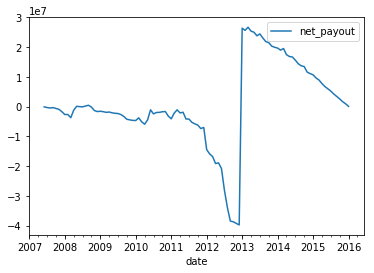

In [147]:
repaymentsThrough2012.plot('date','net_payout')

###Graph of payout structure of loans issued through from 2007-2012

In [148]:
print("Looking at the IRRs by Year of Issuance.  You can observe the (artificial) drop in IRRs for 2013-2015 issuance, as it is effected by the prepay vs. default bias")
for i in range(2007,2016):
    year = i
    repayments = createPaymentsTableYearGroup(dfLoanGroupUnderlying,year)
    irrAnnual = (1+np.irr(repayments.net_payout))**12-1
    print((i,": ", round(irrAnnual,3)))


Looking at the IRRs by Year of Issuance.  You can observe the (artificial) drop in IRRs for 2013-2015 issuance, as it is effected by the prepay vs. default bias
(2007, ': ', -0.015)
(2008, ': ', 0.012)
(2009, ': ', 0.064)
(2010, ': ', 0.074)
(2011, ': ', 0.072)
(2012, ': ', 0.079)
(2013, ': ', 0.038)
(2014, ': ', -0.044)
(2015, ': ', -0.12)


As we can see in the pivot table below, the 2012 G issued bonds have the highest returns

In [149]:
dfRoRs = repayments =  pd.DataFrame({})
for i in range(2007,2015):
  year = i
  for grade in dfLoanGroupUnderlying.grade.unique():
    repayments = createPaymentsTableYearGroup(dfLoanGroupUnderlying,year,grade)
    irrAnnual = (1+np.irr(repayments.net_payout))**12-1
    df = pd.DataFrame({'year':year,'grade':grade,'irrAnnual':irrAnnual},index=[0])
    dfRoRs =dfRoRs.append(df, ignore_index=True)

    
dfRoRs.pivot(index='year', columns='grade', values='irrAnnual')


grade,A,B,C,D,E,F,G
year,,,,,,,
2007,0.077660,0.008974,0.006988,-0.015161,-0.018366,-0.134331,-0.060084
2008,0.061401,0.025609,0.011716,-0.018631,0.028635,-0.047087,-0.001672
2009,0.061725,0.061586,0.068532,0.072781,0.062317,0.017823,0.052570
2010,0.059073,0.074042,0.083928,0.083873,0.091093,0.015582,0.053330
2011,0.050751,0.076746,0.082966,0.102424,0.127012,0.092363,-0.034907
2012,0.052054,0.077528,0.088771,0.102892,0.121441,0.136507,0.188063
2013,0.046921,0.048799,0.038651,0.005780,-0.016518,-0.042694,-0.153118
2014,0.019773,-0.003468,-0.065645,-0.132007,-0.220346,-0.284646,-0.329333


## Part 3: Modeling<br><br>

As an investor, we seek to generate the highest risk-adjusted return possible, given the available universe of investments.  A classic heuristic rule of them for this is to optimize the Sharpe ratio of our portfolio, the expected return less the risk free rate, over the variance of our portfolio.

A solid investing framework would fit the following framework:

*1)	Maximize the Returns of Portfolio
*
    a.	As a portfolio, Identify features that allow us to identify when we should be over/underweight riskier loans (Macro Forecasting). We will ignore this for the purposes of this exercise.
    b.	Given an interest rate, identify the loans that are least likely to default (Loan Level Forecasting)*
2)	Structure our portfolio such that the variance of the expected returns is minimized.*

    a.	Calculate the expected variance of the assets in our portfolio.
    b.	Calculate the expected covariance of assets in our portfolio. We will ignore this for the purposes of our exercise.
    c.	Select our assets to maximize the sharpe ratio of our assets
    
*3)	Distill these rules into an easily interpretable format, to be understandable to an untrained loan decision*

    a.	We will show how extremely simple rules can benefit our portfolio, as well as show how a less-trivial model can yield further benefits

In this exercise, we will compare 3 portfolios.

    a) The baseline - investment in all loans in the LC universe, dollar weighted
    b) A simple heuristic - selecting the highest interest rate loans for a given credit rating, with each loan of equal investment,  in proportion to number of the loans issued in that period.
    c) A model based approach - Selecting the loans with the highest projected Sharpe ratio, as defined by our projected IRR over the historical variance of the credit grade

**Results**
In an effort to handle the extreemly different economic periods in our period of analyis, and given the $$ issued per year increased exponentially, it makes sense to weight the returns by year, rather than by $$ issuance, as it is a closer analogue to what we could expect going forward.

    a.	Baseline - Weighted equally by time (not dollars) - Annual Return: 4.7%, Sharpe .697
    b.	Heuristic - Weighted equally by time (not dollars) - Annual Return: 5.3%, Sharpe 1.15
    c.	Model - Weighted equally by time (not dollars) - Annual Return: 6.6%, Sharpe 2.41
    



In [190]:
dfLoanGroupUnderlyingUsable = dfLoanGroupUnderlying.query("issue_date<'2013-01-01'")


dfLoans_for_analysis = dfLoanGroupUnderlyingUsable[['id','loan_duration','individual_irr','repayment_by_month','last_pymnt_amnt']].merge(dfloan.drop('last_pymnt_amnt',axis=1),left_on='id', right_on='id', how='inner')
dfLoans_for_analysis['purpose_adj'] = np.where(dfLoans_for_analysis.purpose.isin(["credit_card",'debt_consolidation']), dfLoans_for_analysis.purpose,'other')

Risk Free Rates Through Time on a 5 year Treasury


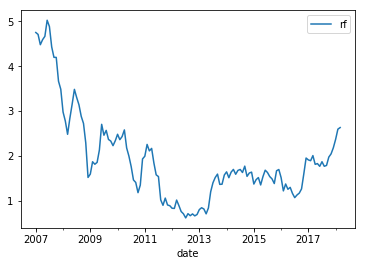

In [191]:
###This table reflects the yields of a 5 year T-Bill through time.  It will be used to calculate sharpe ratios
rf5YearYield=[4.75285714285714,
4.71052631578947,
4.48090909090909,
4.59333333333333,
4.66727272727273,
5.02619047619048,
4.8847619047619,
4.43217391304348,
4.19894736842105,
4.19818181818182,
3.667,
3.4875,
2.98047619047619,
2.779,
2.4835,
2.84136363636364,
3.15333333333333,
3.4852380952381,
3.30318181818182,
3.14190476190476,
2.88428571428571,
2.72636363636364,
2.29166666666667,
1.52181818181818,
1.5965,
1.87157894736842,
1.81590909090909,
1.85809523809524,
2.134,
2.70590909090909,
2.46272727272727,
2.57095238095238,
2.36904761904762,
2.33285714285714,
2.23052631578947,
2.34045454545455,
2.48421052631579,
2.36368421052632,
2.43304347826087,
2.58136363636364,
2.18,
1.99636363636364,
1.76285714285714,
1.46545454545455,
1.41047619047619,
1.1825,
1.35,
1.93454545454545,
1.9945,
2.25789473684211,
2.11347826086957,
2.169,
1.84238095238095,
1.58,
1.541,
1.02130434782609,
0.90047619047619,
1.0615,
0.908,
0.891428571428571,
0.835,
0.831,
1.01727272727273,
0.894761904761905,
0.761818181818182,
0.711428571428571,
0.619523809523809,
0.713913043478261,
0.668947368421053,
0.708571428571429,
0.665,
0.696,
0.805238095238095,
0.846315789473684,
0.8185,
0.710454545454545,
0.840909090909091,
1.2035,
1.40318181818182,
1.52045454545455,
1.596,
1.36681818181818,
1.37105263157895,
1.57619047619048,
1.64666666666667,
1.51578947368421,
1.63952380952381,
1.70095238095238,
1.59285714285714,
1.67904761904762,
1.69954545454545,
1.63142857142857,
1.77380952380952,
1.54590909090909,
1.62055555555556,
1.64,
1.3745,
1.47263157894737,
1.51909090909091,
1.35454545454545,
1.5385,
1.68363636363636,
1.63227272727273,
1.54142857142857,
1.49,
1.38571428571429,
1.67105263157895,
1.69863636363636,
1.51842105263158,
1.222,
1.37590909090909,
1.25809523809524,
1.30047619047619,
1.16636363636364,
1.0715,
1.13076086956522,
1.17209090909091,
1.26658571428571,
1.60219545454545,
1.95487272727273,
1.91199545454545,
1.89502,
2.00896086956522,
1.813885,
1.83059130434783,
1.76983636363636,
1.87212857142857,
1.77087826086957,
1.78929047619048,
1.97523181818182,
2.04688181818182,
2.18389565217391,
2.3702125,
2.59802380952381,
2.63362857142857]

dfRiskFreeMonth= pd.DataFrame({'date':pd.date_range(start='2007-01-01', end='2018-03-01', freq='MS'),'rf':rf5YearYield})



print("Risk Free Rates Through Time on a 5 year Treasury")
dfRiskFreeMonth.plot(x='date',y='rf')

In [192]:
##I'm assuming here that Risk Free rate of 5 year treasury is similar to that of 3 year.  I was unable to find 3 year data
dfLoans_for_analysis = dfLoans_for_analysis.merge(dfRiskFreeMonth,left_on='issue_date', right_on='date', how='inner')


**Heurstic Based Analysis - Selecting Higher Interest Rates given a subgrade, when possible**

SIMPLE ANALYSIS - SELECTING THE HIGHEST INTEREST RATE LOANS, FOR A GIVEN LOAN RATING, BY MONTH

ALLOWING FOR PARTIAL LOAN INVESTMENT. EACH LOAN INVEST FIXED SUM, 1k.

A Fixed, 1k investment per loan will be taken on the top 25% of loans, per issuing month, and sub grade.

In [193]:
topXPercent = .25  ####This parameter toggles what percent of loans per month you target.  Through experimentation, 25% appeared to be close to a local maxima, but was not a tuned parameter

In [194]:
##For each subgrade of credit, select the loan with the highest interest rate, on the topXPercent of Loans
trainSet = dfLoans_for_analysis[['issue_date', 'funded_amnt','int_rate','sub_grade','annual_inc','purpose_adj','dti','individual_irr']]
investByMonth = trainSet[['funded_amnt','sub_grade','issue_date']].groupby(['sub_grade','issue_date']).count().reset_index() 
investByMonth['number_loans_per_class'] = (topXPercent*investByMonth.funded_amnt ).round()
res = investByMonth[['number_loans_per_class','sub_grade','issue_date']]

dfLoans_for_analysisWith_Thresholds = dfLoans_for_analysis.merge(res,left_on=['issue_date','sub_grade'], right_on=['issue_date','sub_grade'], how='inner')
dfLoans_for_analysisWith_Thresholds = dfLoans_for_analysisWith_Thresholds.sort_values(['issue_date','int_rate','id'],ascending=[1,0,1])

dfLoans_for_analysisWith_Thresholds['index'] = dfLoans_for_analysisWith_Thresholds[['sub_grade','issue_date','int_rate']].groupby(['sub_grade','issue_date'])['int_rate'].rank(method='first')
higherInterestLoans = dfLoans_for_analysisWith_Thresholds.query('index<=number_loans_per_class')

In [195]:
def scale_down_lending(constant_value,loanTable):
####THIS FUNCTION TAKES A CONSTANT INVESTMENT PER LOAN, AND SCALES EACH LOAN TO THAT VOLUME.
###I.E. if you have a 1k target, and their are two issuances, 2k and 5k, you target 50% of the former, and 20% of the latter.
###Returns a table of loans, with repayments, last payment, and funding, proportionately scaled
  loanTable['scalar'] = constant_value/loanTable.funded_amnt
  loanTable.last_pymnt_amnt = loanTable.scalar*loanTable.last_pymnt_amnt
  loanTable.repayment_by_month = loanTable.scalar*loanTable.repayment_by_month
  loanTable['funded_amnt'] = constant_value
  return(loanTable)


In [196]:
higherInterestLoans2.head()

,id,loan_duration,individual_irr,repayment_by_month,last_pymnt_amnt,issue_date,member_id,loan_amnt,funded_amnt,funded_amnt_inv,...,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,purpose_adj,date,rf,number_loans_per_class,index,scalar
74736,74014,37,0.112200,32.863135,26.012403,2007-06-01,73890,6450.0,1000,0.0,...,NaN,NaN,NaN,NaN,other,2007-06-01,5.026190,1.0,1.0,0.155039
74743,72998,36,0.096400,32.089143,32.410000,2007-06-01,72992,1000.0,1000,0.0,...,NaN,NaN,NaN,NaN,other,2007-06-01,5.026190,1.0,1.0,1.000000
74561,90106,37,0.147000,30.600723,160.565000,2007-07-01,90090,10000.0,1000,350.0,...,NaN,NaN,NaN,NaN,other,2007-07-01,4.884762,1.0,1.0,0.100000
74545,98360,18,-0.235814,37.274661,34.365385,2007-07-01,98355,2600.0,1000,950.0,...,NaN,NaN,NaN,NaN,other,2007-07-01,4.884762,1.0,1.0,0.384615
74597,91126,31,0.131200,33.827871,197.558879,2007-07-01,91067,5350.0,1000,625.0,...,NaN,NaN,NaN,NaN,other,2007-07-01,4.884762,1.0,1.0,0.186916


In [200]:
###Adjusting each loan to be the same size, comparing this against the equal weighted, but un adjusted interst rates###
###It appears we gain 40bps via selecting the highest interest rate, but cost ourselves 10 bps by not dollar weighting.

higherInterestLoans2 = scale_down_lending(1000, higherInterestLoans)

repayments2 = createPaymentsTable(dfLoanGroupUnderlying.query("issue_date<= '2012-12-01'"))
irrAnnual = (1+np.irr(repayments2.net_payout))**12-1
print("Higher Interest Rate, Constant Size")
print(irrAnnual)

repaymentsConstantSize = scale_down_lending(1000, dfLoanGroupUnderlying.query("issue_date<= '2012-12-01'"))
repaymentsConstant = createPaymentsTable(repaymentsConstantSize.query("issue_date<= '2012-12-01'"))
irrAnnual = (1+np.irr(repaymentsConstant.net_payout))**12-1
print("Average Interest Rate, Constant Size")
print(irrAnnual)


repayments2 = createPaymentsTable(higherInterestLoans2)
irrAnnual = (1+np.irr(repayments2.net_payout))**12-1
print("Average Interest Rate, Dollar Weighted Size")
print(irrAnnual)



Higher Interest Rate, Constant Size
0.07317623012373353
Average Interest Rate, Constant Size
0.0684887583685152
Average Interest Rate, Dollar Weighted Size
0.07229145809202886


**Model Based Analysis**

We're going to use a **random forest** to predict an individual loans IRR.
We  have quick and dirty calculated the IRR for a loan by using the interest rate if the loan was paid in full, and pretending the entiry loan payment was received on the final payment date if theere was a default.  While this understates the IRR very slightly as it ignores interest payments on loans that defaulted, it is computationally very fast. Hopefully won't hurt our model too much. 
That is our dependent variable. 

While many features are native to the dataset, we're going to bring in one more, chiefly default rate in the month prior.  One of the nice things about having a rich consumer dataset, is it allows you to track consumer defaults very quickly!
A more in-depth analysis would identify uncorrelated features that were correlated to default rates.  This analysis simply seeks to prove that a random forest model, with a variety of factors, and one derived charateristic, is still likely predictive. Certainly more could be done on feature engineering.

Feature list:

* Prior Monthly Default Rate 
* Debt To Income
* Income
* Funded Amount,
* Interest Rate
* Credit Sub Grade
* Lon Purpose
* Home Ownership.

Given a forecast for IRR of the asset, and knowing the historical variance of assets, we will be able to forecast an asset level sharpe ratio.
Given this asset-level sharpe ratio, we will invest a uniform sum (1k) across the top X% of bonds.




In [201]:
from sklearn.ensemble import RandomForestRegressor
dfLoanBook = dfloanUseful
dfLoanBook.shape[0]

loanIssues = ['Does not meet the credit policy. Status:Charged Off','Charged Off','Default','Late (31-120 days)','Late (16-30 days)']
dfLoanBook['loan_status'] = dfLoanBook.loan_status.str.strip()
dfLoanBook['fully_paid'] = np.where(dfLoanBook.loan_status.isin(loanIssues),0,1)


In [202]:
dfLoanBook.query("fully_paid == 1").loan_status.unique()

array(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid',
       'Current', 'In Grace Period', 'Issued'], dtype=object)

In [203]:
##CONSTRUCT A FEATURE - THE DEFAULT RATE LAST MONTH
dfDefaultRate = pd.DataFrame({})
for randomMonth in months:
  loansDefaultInMonth = dfLoanBook[(dfLoanBook.issue_date<randomMonth) & (dfLoanBook.last_pymnt_date==randomMonth) & (dfLoanBook.fully_paid==0)].shape[0]
  activeLoans = dfLoanBook[(dfLoanBook.issue_date<randomMonth) & (dfLoanBook.last_pymnt_date>=randomMonth)].shape[0]
  df = pd.DataFrame({'activeLoans':activeLoans,'loansDefaultInMonth':loansDefaultInMonth,'date':randomMonth},index=[0])
  dfDefaultRate = dfDefaultRate.append(df,ignore_index=True)
    

dfDefaultRate = dfDefaultRate.query("activeLoans>0")


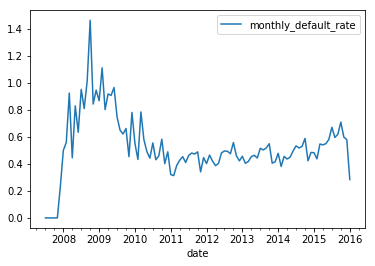

In [206]:
###We can quickly see when the default rate has spiked up. We can see the default rate rising very quickly in 2008.  This is probably a good red flag for lending.
dfDefaultRate['monthly_default_rate'] = 100*dfDefaultRate.loansDefaultInMonth/dfDefaultRate.activeLoans
dfDefaultRate.plot(x='date',y='monthly_default_rate')



In [207]:
##Lag the feature by 1 month, as we only know LAST months default rate, when seeking to issue new loans.
dfDefaultRate['defaultRateLastMonth'] = dfDefaultRate.monthly_default_rate.shift(1)
dfDefaultRate.loc[1,'defaultRateLastMonth']=0

In [210]:
####Remove rows with missing values.
####Convert Strings to categoricals
trainSet = dfLoans_for_analysis[['id','issue_date', 'funded_amnt','int_rate','sub_grade','annual_inc','purpose_adj','dti','individual_irr','home_ownership']]
trainSet = trainSet.merge(dfDefaultRate[['date','defaultRateLastMonth']],left_on='issue_date',right_on='date',how='inner')
trainSet = trainSet[trainSet.annual_inc.isna() == False]
trainSet = trainSet[trainSet.dti.isna() == False]
trainSet['purpose_adj'] = trainSet.purpose_adj.astype('category')
trainSet['home_ownership'] = trainSet.home_ownership.astype('category')
grades = pd.DataFrame({'sub_grade' :trainSet.sort_values('sub_grade').sub_grade.unique()})
grades['grade_rank'] = np.arange(grades.shape[0], 0,-1)
trainSet = trainSet.merge(grades,left_on='sub_grade',right_on='sub_grade',how='inner')

*Discussion on choice to split data by month, rather than sample randomly*
I am choosing to split the data on a month, rather than randomly sampling. This is an important decision.

If we split the data randomly, or by random month we run the risk of substantially overfitting, as the loans are clearly correlated through time.  Other features that are co-correlated with time (for example last months default rate) would be over-fitted to. This would be information leakage - i.e. you don't know in 2008 that the recent uptick in default rates is correlated with a deep economic recession in 2009.  By splitting on a certain month, rather than selecting random points, we somewhat reduce this risk of overfitting. 

It is certainly not fully reduced though. Ideally, we'd use 2007&2008 to predict loans issued in 2012.... and vice versa, but we simply don't have enough time range in order to make that prediction.  There's potentially more we could do (use 2014/2015 issuance 36 month loans to predict 2010/2011,, etc), but it's beyond the scope of this assignment

I'm in particular interested in the performance of the model, based upon 2012, from 2007-2011, i.e. a period that captures the financial crisis.
If our model performs well of this period, it's reaonsable that we have gained some edge, and haven't just overfit our way to perceived profit.

Additionally, by looking at returns by year, rather than on a dollar or loan weighted basis, we can get a better sense of what our returns would be.

In [211]:
splitDate = pd.to_datetime('2012-01-01')

In [212]:
train = trainSet[trainSet.issue_date<splitDate]
y = train.individual_irr
train = train[['funded_amnt','int_rate','grade_rank','annual_inc','purpose_adj','dti','home_ownership','defaultRateLastMonth']]
train = pd.get_dummies(train)
test = trainSet[trainSet.issue_date>=splitDate][['id','funded_amnt','int_rate','grade_rank','annual_inc','purpose_adj','dti','home_ownership','defaultRateLastMonth']]
test = pd.get_dummies(test)

rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(train, y)
#train.dtypes

test = trainSet[trainSet.issue_date>=splitDate][['funded_amnt','int_rate','grade_rank','annual_inc','purpose_adj','dti','home_ownership','defaultRateLastMonth']]
test = pd.get_dummies(test)

testActual = trainSet[trainSet.issue_date>=splitDate]
testActual['predicted_irr'] = rf.predict(test)
predictedIrrLate = testActual[['predicted_irr','id']]


In [213]:
###Train on the first half of the data, predict on the outsample (2012)
train = trainSet[trainSet.issue_date<splitDate]
y = train.individual_irr
train = train[['funded_amnt','int_rate','grade_rank','annual_inc','purpose_adj','dti','home_ownership','defaultRateLastMonth']]
train = pd.get_dummies(train)
test = trainSet[trainSet.issue_date>=splitDate][['funded_amnt','int_rate','grade_rank','annual_inc','purpose_adj','dti','home_ownership','defaultRateLastMonth']]
test = pd.get_dummies(test)

rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(train, y)
#train.dtypes

testActual = trainSet[trainSet.issue_date>=splitDate]
testActual['predicted_irr'] = rf.predict(test)
predictedIrrLate = testActual[['predicted_irr','id']]



In [214]:
###Train on the second half of the data, predict on the outsample (2007-2011)
train = trainSet[trainSet.issue_date>=splitDate]
y = train.individual_irr
train = train[['funded_amnt','int_rate','grade_rank','annual_inc','purpose_adj','dti','home_ownership','defaultRateLastMonth']]
train = pd.get_dummies(train)
test = trainSet[trainSet.issue_date<splitDate][['funded_amnt','int_rate','grade_rank','annual_inc','purpose_adj','dti','home_ownership','defaultRateLastMonth']]
test = pd.get_dummies(test)

rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0)
rf.fit(train, y)
#train.dtypes

testActual = trainSet[trainSet.issue_date<splitDate]
testActual['predicted_irr'] = rf.predict(test)
predictedIrrEarly = testActual[['predicted_irr','id']]

In [215]:
##Combine the two outsamples
combined = predictedIrrEarly.append(predictedIrrLate,ignore_index=True)
bestLoans = combined.merge(dfLoans_for_analysis,left_on='id',right_on= 'id')

In [216]:
##Looking at the feature importance from one of the models
print("Features sorted by their score:")
print(pd.DataFrame(rf.feature_importances_, index=train.columns, 
                          columns=["Importance"]))

##Looking at correlation with the prediction (IRR) and the actual IRR
from scipy.stats import pearsonr
pearson = pearsonr(bestLoans.individual_irr, bestLoans.predicted_irr)
print(f'Test data Pearson correlation: {pearson[0]:.3}')


Features sorted by their score:
                                Importance
funded_amnt                       0.192483
int_rate                          0.096303
grade_rank                        0.071363
annual_inc                        0.173540
dti                               0.299263
defaultRateLastMonth              0.093242
purpose_adj_credit_card           0.005790
purpose_adj_debt_consolidation    0.009512
purpose_adj_other                 0.009107
home_ownership_MORTGAGE           0.018114
home_ownership_NONE               0.000365
home_ownership_OTHER              0.000195
home_ownership_OWN                0.011407
home_ownership_RENT               0.019315
Test data Pearson correlation: 0.0664


In [217]:
##Calculate a Standard Deviation By Loan Grade. This is admittedly cheating because I'm using future information, but we'd probably have this info historically.
topXPercent = .25
standardDeviation = bestLoans[['individual_irr','grade']].groupby('grade').agg([np.std])
standardDeviation.columns = standardDeviation.columns.droplevel(0)
standardDeviation = standardDeviation.reset_index()
bestLoansStandardDeviation = bestLoans.merge(standardDeviation,left_on='grade',right_on='grade',how='inner')
#bestLoansStandardDeviation

In [218]:
###Given the predicted IRR, and the historical variance, we have an approximation of an asset level sharpe ratio
###Given this asset level sharpe ratio, select the most attractive loans - i.e. the loans with the highest sharpe, and add them to your portfolio.

bestLoansStandardDeviation['loan_level_sharpe'] =  (bestLoansStandardDeviation.predicted_irr-bestLoansStandardDeviation.rf/100)/bestLoansStandardDeviation['std']

res = bestLoansStandardDeviation[['issue_date','loan_level_sharpe']].groupby('issue_date').count().reset_index() 
res['number_of_loans_per_period'] = (res['loan_level_sharpe']*topXPercent).round()

bestLoansStandardDeviation= bestLoansStandardDeviation.merge(res[['number_of_loans_per_period','issue_date']],left_on='issue_date',right_on='issue_date',how='inner')

In [219]:
bestLoansStandardDeviation['sharpe_rank'] =bestLoansStandardDeviation[['loan_level_sharpe','issue_date']].groupby(['issue_date'])['loan_level_sharpe'].rank(method='first',ascending=0)

selectedBest = bestLoansStandardDeviation.query("sharpe_rank<=number_of_loans_per_period")
selectedBest.head()



,predicted_irr,id,loan_duration,individual_irr,repayment_by_month,last_pymnt_amnt,member_id,loan_amnt,funded_amnt,funded_amnt_inv,...,credit_pull_date,earliest_credit,last_pymnt_date,purpose_adj,date,rf,std,loan_level_sharpe,number_of_loans_per_period,sharpe_rank
1,0.079212,1069522,37,0.1065,392.218056,417.61,1304589,12400.0,12400.0,12400.0,...,2014-12-01,2005-07-01,2015-01-01,credit_card,2011-12-01,0.891429,0.2094,0.335709,354.0,116.0
6,0.084098,1067090,37,0.1065,292.948333,6.65,1301465,9000.0,9000.0,9000.0,...,2016-01-01,1998-09-01,2015-01-01,credit_card,2011-12-01,0.891429,0.2094,0.359042,354.0,85.0
10,0.059363,1063126,37,0.1065,189.715000,204.10,1295634,6000.0,6000.0,6000.0,...,2014-12-01,1997-01-01,2015-01-01,other,2011-12-01,0.891429,0.2094,0.240923,354.0,327.0
11,0.098785,1065234,37,0.1065,316.301667,336.85,1299108,10000.0,10000.0,10000.0,...,2014-12-01,2000-05-01,2015-01-01,debt_consolidation,2011-12-01,0.891429,0.2094,0.429183,354.0,21.0
15,0.065400,1063680,16,0.1065,259.880000,5025.51,1296245,8000.0,8000.0,8000.0,...,2013-05-01,1999-04-01,2013-04-01,debt_consolidation,2011-12-01,0.891429,0.2094,0.269752,354.0,258.0


In [220]:
selectedBest.query("sharpe_rank<=1").head()[['loan_level_sharpe','individual_irr','predicted_irr']]

,loan_level_sharpe,individual_irr,predicted_irr
389,0.544710,0.1269,0.122977
1830,0.564394,0.1269,0.127264
3330,0.530009,0.1242,0.121599
4572,0.509754,0.1171,0.115747
6054,0.399726,0.0963,0.086027


**Comparing the Three Models**


In [221]:
selectedBest2 = scale_down_lending(1000, selectedBest)

In [225]:
###For each year, calculate the returns of the porfolio by year.
year_returns = pd.DataFrame({})
for i in range(2007,2013):
  year = i
  repaymentsBase = createPaymentsTableYearGroup(dfLoanGroupUnderlying,year)
  repaymentsHigherInterest = createPaymentsTableYearGroup(higherInterestLoans2,year)
  repaymentsBest = createPaymentsTableYearGroup(selectedBest2,year)
  
  baseline = (1+np.irr(repaymentsBase.net_payout))**12-1 
  high = (1+np.irr(repaymentsHigherInterest.net_payout))**12-1
  best = (1+np.irr(repaymentsBest.net_payout))**12-1
  
  dt = pd.DataFrame({'baseline':baseline,'higher_interest':high,'best':best,'year':year},index=[0])
  year_returns = year_returns.append(dt,ignore_index=True)

dfRiskFreeMonth['year']=dfRiskFreeMonth.date.dt.year
dfRiskFreeAnnual = dfRiskFreeMonth[['rf','year']].groupby('year').mean().reset_index()
year_returns = year_returns.merge(dfRiskFreeAnnual,left_on='year',right_on='year',how='inner')
year_returns

,baseline,best,higher_interest,year,rf
0,-0.014911,0.052149,0.008745,2007,4.424971
1,0.012168,0.032216,0.025398,2008,2.799344
2,0.064195,0.075637,0.063271,2009,2.190713
3,0.073879,0.080699,0.077982,2010,1.928708
4,0.071735,0.076070,0.067611,2011,1.523414
5,0.079018,0.079992,0.078299,2012,0.760270


In [227]:

best= pd.DataFrame({'type':'Best','annualized':year_returns['best'].mean(),'sharpe':(year_returns['best'] - year_returns['rf']/100).mean()/np.std(year_returns['best'])    },index=[0])
higher = pd.DataFrame({'type':'Higher Rates','annualized':year_returns['higher_interest'].mean(),'sharpe':(year_returns['higher_interest'] - year_returns['rf']/100).mean()/np.std(year_returns['higher_interest'])    },index=[0])
base = pd.DataFrame({'type':'Base','annualized':year_returns['baseline'].mean(),'sharpe':(year_returns['baseline'] - year_returns['rf']/100).mean()/np.std(year_returns['baseline'])    },index=[0])
best.append(higher,ignore_index=True).append(base,ignore_index=True)

,annualized,sharpe,type
0,0.066127,2.414917,Best
1,0.053551,1.151738,Higher Rates
2,0.047680,0.697033,Base


**Explanation Of Outperformance of Model vs. Base:**

The model takes a much more conservative asset class (more high grade loans) than the baseline, as we can see below.  This helps it significantly in 2007/08.  These loans have considerably higher sharpe ratios.


In [282]:
###While not precise, a quick heuristic shows the higher rated loans have historically superior sharpe ratios
dfLoanGroupUnderlying.query("issue_date<='2012-12-01'")[['grade','individual_irr']].groupby(['grade']).agg(['mean','std']).reset_index()

grade individual_irr          
                  mean       std
0     A       0.042420  0.150862
1     B       0.054565  0.209374
2     C       0.050681  0.258069
3     D       0.050828  0.287604
4     E       0.043619  0.310598
5     F      -0.009002  0.372476
6     G      -0.016028  0.369335

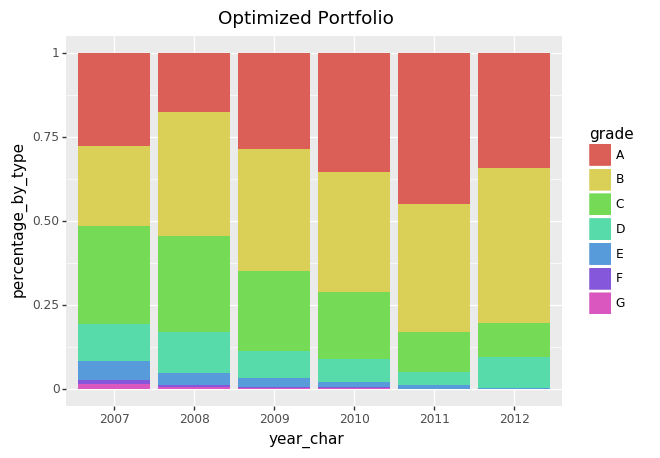

<ggplot: (-9223363292987460664)>


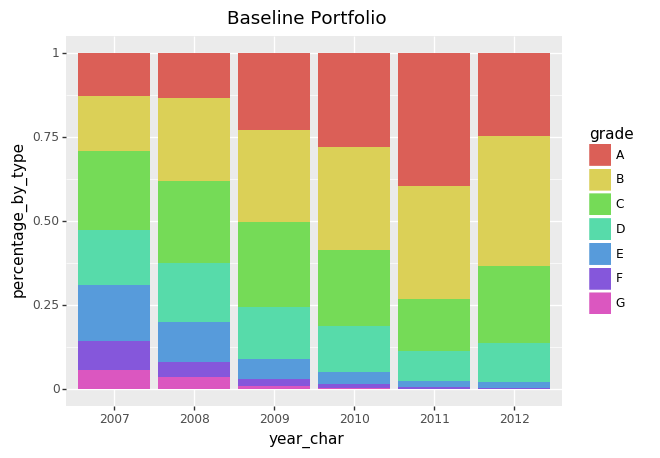

<ggplot: (8743867464859)>


In [276]:
selectedBest2['year'] = selectedBest2['issue_date'].dt.year 
df = selectedBest2.groupby(['grade','year']).count().reset_index()[['grade','scalar','year']]
df2 = df.groupby('year').sum().reset_index()
df2['total']=df2.scalar
df3 = df.merge(df2[['total','year']],left_on='year',right_on='year',how='inner')
df3['percentage_by_type'] = df3.scalar/df3.total
df3['year_char'] = df3.year.astype('category')
print(ggplot(df3,aes(x='year_char',y='percentage_by_type',fill='grade'))+geom_bar(stat='identity') + ggtitle("Optimized Portfolio"))

dfLoanGroupUnderlying['year'] = dfLoanGroupUnderlying['issue_date'].dt.year 
df = dfLoanGroupUnderlying.query("issue_date<='2012-12-01'").groupby(['grade','year']).count().reset_index()[['grade','int_rate','year']]
df2 = df.groupby('year').sum().reset_index()
df2['total']=df2.int_rate
df3 = df.merge(df2[['total','year']],left_on='year',right_on='year',how='inner')
df3['percentage_by_type'] = df3.int_rate/df3.total
df3['year_char'] = df3.year.astype('category')
print(ggplot(df3,aes(x='year_char',y='percentage_by_type',fill='grade'))+geom_bar(stat='identity') + ggtitle("Baseline Portfolio"))